In [17]:
import numpy    as     np
import matplotlib.pyplot as plt
from   scipy import integrate
from dataclasses import dataclass,astuple,asdict # for C-like structure

The governing equations of a spring-slider system goverend by the rate- and state- friction with two state variables are described in Becker (2000) equations 1-3, and we used the simplified version earlier for the one state variable slider with the Ruina law, 

\begin{align}
\frac{d x}{dT} &= e^x (-\kappa + y + \lambda x) + \kappa v'_l  \\
\frac{d y}{dT} &= \kappa (v'_l - e^x) \\
\frac{d v_l}{dT} &= v'_l\\
\end{align}
with 
$
x = \ln\left(\frac{v}{v_0}\right),
$
and
$
y = \frac{\tau - \tau_0}{a}.
$

If we set $v_l = v_0$, then and allow for two state variables, $\theta_1$ and $\theta_2$, we can write
\begin{align}
\dot x =& e^x ((\beta_1 - 1) x + y -z) + \dot y - \dot z \\
\dot y =& (1 - e^x) \kappa \\
\dot z =& -e^x \rho (\beta_2 x + z)
\end{align}

where we now have a bunch more parameters 
\begin{align}
\beta_i =& b_i/a \\
\kappa =& KD_c^1/a \\
z =&\beta_2 ln(V_* \theta_2 / D_c^2) \\
\rho = &D_c^1 / D_c^2 \\
T =& V_0 t / D_c^1 
\end{align}

It also turns out that the new critical stiffness for this system is a complicated combination of the parameters

$
\kappa_c = 
\frac{
\kappa_c^0 + \rho(2\beta_1 + (\beta_2 - 1)(2+\rho))+\sqrt{4\rho^2(\kappa_c^0+\beta_2)+(\kappa_c^0+\rho^2(\beta_2-1))^2}}
    {2+ 2\rho}
$
where, from before,
$
\kappa_c^0 = \beta-1
$ 

Let's define the parameter structure and a function computing $\kappa_c$.

In [18]:
@dataclass
class parameters:
    beta1 :float     = 1.
    beta2 :float     = 0.84
    rho   :float     = 0.048
    kappa :float     = 1

def calcKappac(kappaPrime, par):
    beta1    = par.beta1
    beta2    = par.beta2
    rho      = par.rho
    kappaCr1 = beta1 - 1.
    kappaCr2 = (kappaCr1 + rho*(2*beta1 + (beta2 - 1.)*(2.+rho)) + \
                (4*rho**2*(kappaCr1 + beta2) + (kappaCr1 + rho**2*(beta2 - 1.)**2))**0.5) 
    kappaCr2 = kappaCr2/(2. + 2.*rho) # eq 10 in Becker (2000).
    kappa    = kappaCr2 * kappaPrime
    return kappa

Let's define the ODEs.

In [28]:
# define the ODEs for the system.
def dxdt(x,t,beta1,beta2,rho,kappa):
    exp_x  = np.exp(x[0])
    f1 = (1. - exp_x) * kappa # \dot{y}
    f2 = -exp_x * rho * (beta2 * x[0] + x[2]) #\dot{z}
    f0 =  exp_x*((beta1 - 1.)*x[0] + x[1] - x[2]) + f1 - f2 # \dot{x} 
    return [f0,f1,f2]
def ode_solver_scipy(xInit,t, par):
    sol     = integrate.odeint(dxdt, xInit, t, astuple(par), rtol=1e-16)
    return sol

We want to test different $\kappa' = \kappa/\kappa_c$ values, so let's define a driver function.

In [29]:
# driver function, provide kappa', in multiples of critical kappa
def main(kappaPrime, T1, Tshow, dt, plot = True):
    par      = parameters()
    t        = np.linspace(0, T, Nt)
    
    par.kappa= calcKappac(kappaPrime, par) # convert kappa' to actual kappa
    xInit    = [0.05, 0., 0.] # Figure 2 in Becker (2000).
    sol      = ode_solver_scipy(xInit,t,par)
    
    if plot == True:
        
        Nt1   = int(T1/dt)
        fig   = plt.figure()
        ax    = plt.axes(projection='3d')
        pind = range(Nt1,Nt,1)
        ax.plot3D(sol[pind,0], sol[pind,1], sol[pind,2])   
        ax.grid()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()
        
        
    return sol

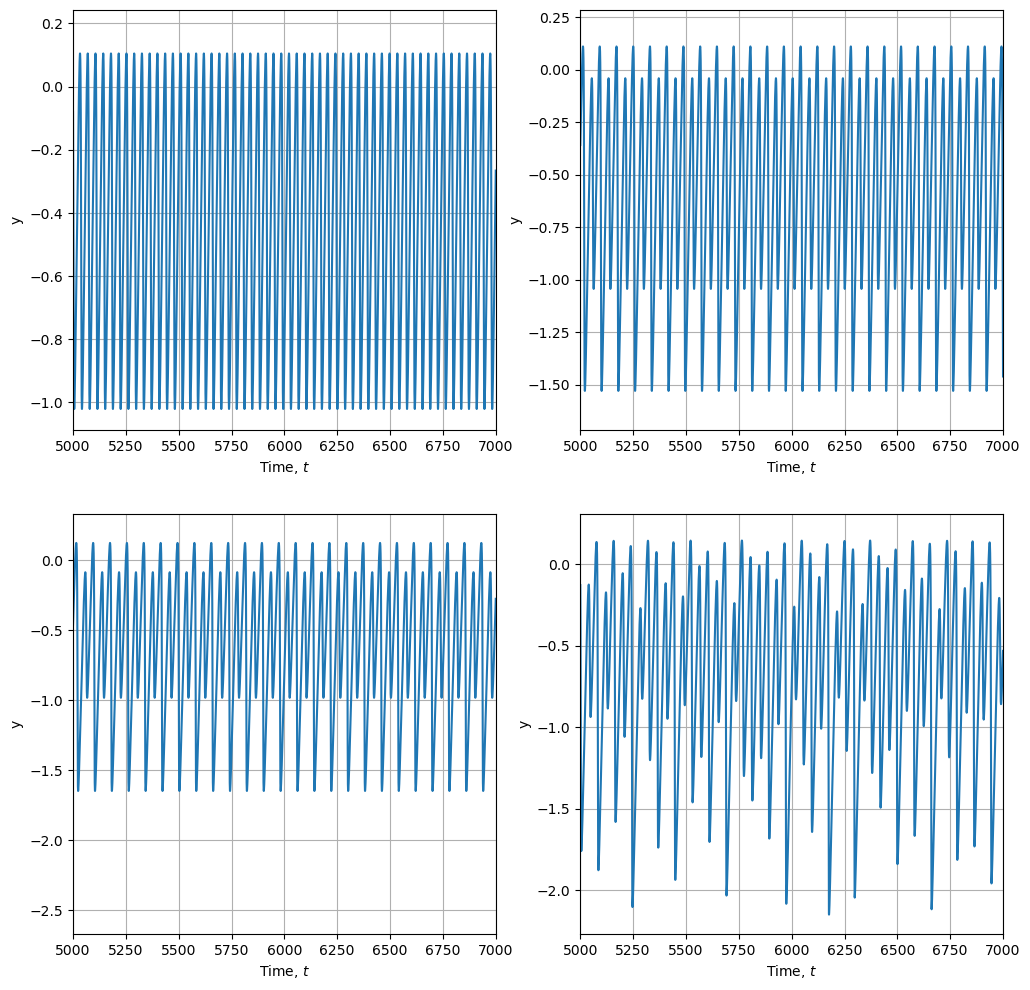

In [63]:
T1        = 5000       # starting time to show results
Tshow     = 2000        # time window to show the results
T         = T1 + Tshow # total time of the series
dt        = 0.04       # integration time step size
Nt        = int(T/dt)  # total time steps
t         = np.linspace(0, T, Nt) # creating time series
res       = np.zeros((Nt,3,4))    # creating zero matrix to store four time series
res1      = np.zeros((Nt,3,4))

kappaPrime= 0.90 # period 2
res[:,:,0]  = main(kappaPrime, T1, Tshow, dt, plot=False)

kappaPrime= 0.86 # period 4
res[:,:,1]  = main(kappaPrime, T1, Tshow, dt, plot=False)

kappaPrime= 0.856 # period 8
res[:,:,2]  = main(kappaPrime, T1, Tshow, dt, plot=False)

#kappaPrime= 0.8552 # period 16
#kappaPrime = 0.85254 # chaotic
kappaPrime = 0.85
#kappaPrime = 0.8534
res[:,:,3]  = main(kappaPrime, T1, Tshow, dt, plot=False)


fig       = plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    if(i < 4):
        plt.plot(t, res[:,1,i])
        plt.xlabel("Time, $t$")
        plt.ylabel("y")
        plt.xlim(left = T1, right = T)
    else:
        plt.plot(res[:,1,i],res[:,2,i])
    
    plt.grid()
    

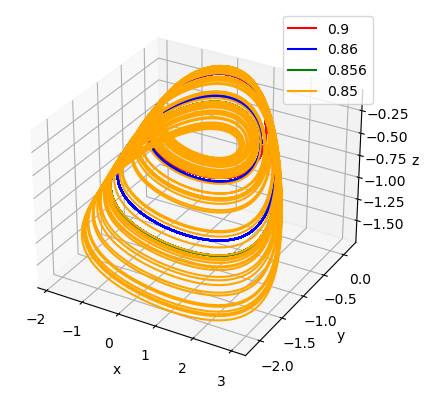

In [62]:
# plot 3D phase space trajectories for the four cases.
Nt1   = int(T1/dt)
col   = ['red', 'blue', 'green', 'orange']
legend= ['0.9', '0.86', '0.856', '0.85']
fig   = plt.figure()
ax    = plt.axes(projection='3d')

pind = range(Nt1,Nt,1)
for i in range(4):
    ax.plot3D(res[pind,0,i], res[pind,1,i], res[pind,2,i], col[i], label=legend[i])   
    ax.grid()
#ax.set_title('Phase space trajectories');
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.show()

In [59]:
from   ipywidgets           import *
from   IPython.display      import display
w = interactive(main, kappaPrime   = (0.8, .9, 0.01), 
               T1=T1, Tshow=Tshow, dt=dt, plot=True)
display(w)


interactive(children=(FloatSlider(value=0.8500000000000001, description='kappaPrime', max=0.9, min=0.8, step=0…